# Convolutional Network for MNIST Predictions. 
In this notebook, I will be using a convolutional architecture rather than a fully connected network. The architecture I am adopting is LeNet-5, which has recorded an error rate as low as 0.95 (or %99.05 accurate). I don't know if I will get quite those results, but let's try!

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from sklearn import model_selection

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from collections import OrderedDict

## Custom Dataset Object
Since the dataset provided by Kaggle is not in image format, we can define a custom MNIST dataset object in PyTorch. In the Kaggle dataset, each row of the .csv file represents a single image and its label. The first entry in the row is the image label, while the other 784 entries in the row are the unstacked image pixel values. 

For a convolutional network, we will need to transform those row vectors back into 3D tensors representing actual image data.

In [2]:
class MNIST(Dataset):
    def __init__(self, df, labels=True, transform=None):
        
        self.df = df
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
   
        if self.labels:
            label = self.df.iloc[index, 0]
            data  = self.df.iloc[index, 1:].to_numpy(np.uint8).reshape(28,28, 1)
            if self.transform:
                data = self.transform(data)
            return data, label
    
        data  = self.df.iloc[index].to_numpy(dtype=np.uint8).reshape(28,28, 1)
        
        if self.transform:
            data = self.transform(data)
        
        return data

## Transforms, Augmentation and Datasets and DataLoaders

Data augmentation is a way to artificially increase the size of the training data. I say artificially, because if you look at the custom dataset class above, you will see that augmentations and transforms are randomly applied on the fly in the `__getitem__` method. What this means is that the amount of data is actually the same, but each epoch a randomly different version of that data will be seen. For this reason, as we add data augmentation, we must also increase the number of epochs to combat under-fitting. 

The right number of augmentations and epoch increases was done by holding all variables in strict control, and introducing one augmentation at a time. After a new augmentation was added, I slowly increased the number of training epochs while monitoring validation loss.

Below, we also define very basic transforms that will also apply to the validation set. First, we transform each 28x28 numpy array into a 1x28x28 torch image tensor. Then we normalize the data to help convergence.

In [3]:
augment = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomRotation(10, fill=(0,)),
                                transforms.RandomPerspective(),
                                transforms.RandomAffine(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

tfs = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,))])

Let's read in our Kaggle training data, split it (25% validation hold out) and get it into `DataLoaders`:

In [4]:
train_df = pd.read_csv('data/train.csv')
X, y = train_df.iloc[:, 1:], train_df.iloc[:, 0]
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(X, y)

trainset = MNIST(pd.concat([y_train, x_train], axis=1), transform=augment)
validset = MNIST(pd.concat([y_valid, x_valid], axis=1), transform=tfs)

trainload = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
validload = DataLoader(validset, batch_size=32, shuffle=True, num_workers=4)

Just to make sure that everything is looking good before we get started, let's take a look at a few images:


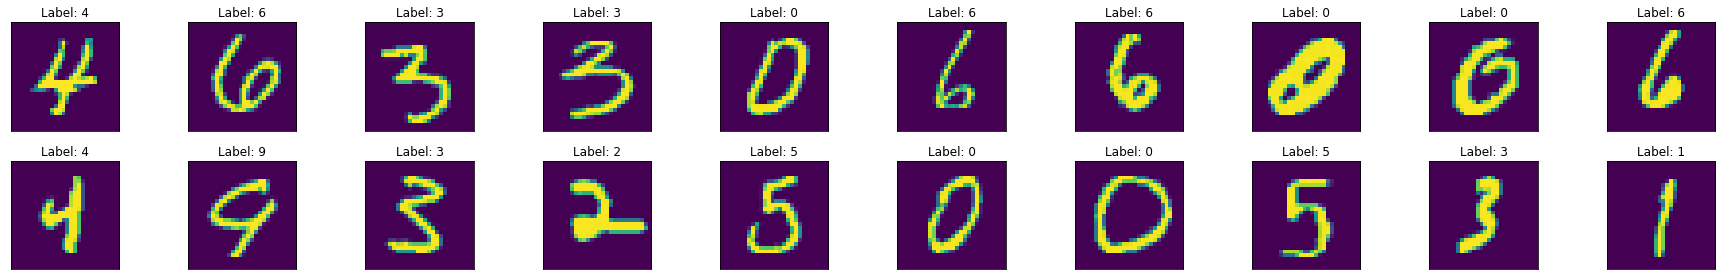

(torch.float32, torch.Size([1, 28, 28]), torch.Size([32, 1, 28, 28]))

In [5]:
images, labels = iter(validload).next()

fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.set_title(f'Label: {labels[i].item()}')
    ax.imshow(images[i].squeeze())

plt.tight_layout()
plt.show()

images[0].dtype, images[0].shape, images.shape

## Defining a Model
I'm going to define my model based on LeNet-5. This is a modified version, where all 6 features of C1 and S2 are run through C3. The original version only had a partial mapping. LeNet-5 was my attempt to take what I learned in the Udacity PyTorch course, read up on a new architecture and implement it myself. There are many others out there, but this one is quite famous for being a "classic" architecture.

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU()
        )
        
        self.out = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return self.out(x)

Now that our model is defined, let's create an instance of it and move it to GPU:

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet()
model = model.to(device)

## Training the Network:
Now that the model has been defined, initialized and moved to GPU, we can begin training. 

### What you can't see from the cell below:
I ran this cell multiple times to get my final result. Here is my process: 

1. I started with a learning rate of `0.0005` and applied learning rate decay through `lr_scheduler`. My initial run was 30 epochs, which I settled on after experimenting with adding a single augmentation at a time, then measuring the number of additional epochs required to combat under-fitting. I'll add a note at the bottom to expand on this.

2. Once the initial 30 epochs are run, repeat:
    1. Take note of final learning rate
    2. Modify optimizer learning rate to equal final learning rate from last run
    3. Run for 10 more epochs.

Using this process, my validation loss and leaderboard rankings continued to improve with this process, but I ran out of submission attempts on Kaggle. You may try to continue this process to get an even better score. 

In [8]:
opt = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=7)
criterion = nn.CrossEntropyLoss()
epochs = 40

train_loss = []
valid_loss = []
accuracy   = []
valid_low = np.Inf


for e in range(epochs):
    running_tl = 0
    running_vl = 0
    running_ac = 0
    
    # backprop and and update
    model.train()
    for images, labels in trainload:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        t_cel = criterion(model(images.float()), labels)
        t_cel.backward()
        opt.step()
        running_tl += t_cel.item()
        
    # validation pass    
    with torch.no_grad():
        model.eval()
        for images, labels in validload:
            images, labels = images.to(device), labels.to(device)
            scores = model(images.float())
            ps = F.softmax(scores, dim=1)
            v_cel = criterion(scores, labels)
            pred = torch.argmax(ps, dim=1)
            running_ac += (pred == labels).cpu().numpy().mean()
            running_vl += v_cel.item()
    
    # Decay Learning Rate:
    print(f'Epoch {e} Learning Rate: {opt.param_groups[0]["lr"]} Validation Loss: {v_cel}')
    scheduler.step(v_cel)

    # get loss metrics for plotting later
    train_loss.append(running_tl/len(trainload))
    valid_loss.append(running_vl/len(validload))
    accuracy.append(running_ac/len(validload))

Epoch 0 Learning Rate: 0.0005 Validation Loss: 0.0934830904006958
Epoch 1 Learning Rate: 0.0005 Validation Loss: 0.16870176792144775
Epoch 2 Learning Rate: 0.0005 Validation Loss: 0.0025148391723632812
Epoch 3 Learning Rate: 0.0005 Validation Loss: 0.07527768611907959
Epoch 4 Learning Rate: 0.0005 Validation Loss: 0.002400636672973633
Epoch 5 Learning Rate: 0.0005 Validation Loss: 0.0017012357711791992
Epoch 6 Learning Rate: 0.0005 Validation Loss: 0.014811038970947266
Epoch 7 Learning Rate: 0.0005 Validation Loss: 0.04078638553619385
Epoch 8 Learning Rate: 0.0005 Validation Loss: 0.002027273178100586
Epoch 9 Learning Rate: 0.0005 Validation Loss: 0.050248146057128906
Epoch 10 Learning Rate: 0.0005 Validation Loss: 0.003622293472290039
Epoch 11 Learning Rate: 0.0005 Validation Loss: 0.07519364356994629
Epoch 12 Learning Rate: 0.0005 Validation Loss: 0.0013098716735839844
Epoch 13 Learning Rate: 0.0005 Validation Loss: 0.001346588134765625
Epoch 14 Learning Rate: 0.0005 Validation Loss:

## Plotting Our Metrics:

Note that validation loss is lower than training loss because the validation pass is run __after__ weights are updated by back-propagation. In other words, the model is improved before validation loss is measured, and so it gets a little boost.

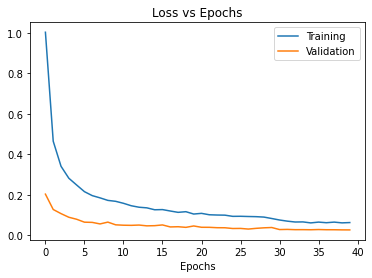

In [9]:
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.legend()

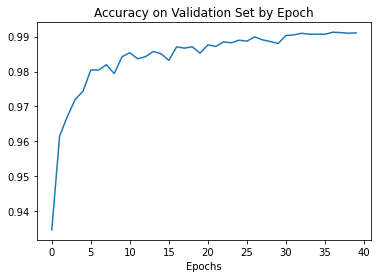

In [10]:
plt.title('Accuracy on Validation Set by Epoch')
plt.xlabel('Epochs')
plt.plot(accuracy)

In [11]:
torch.save(model.state_dict(), 'alltrans_50e.pt')
accuracy[-1]

0.9910714285714286

# Predictions of Kaggle Competition Data:
Now that we have a model that is doing quite well on validation set, let's put it to the test in our competition.

In [12]:
comp_data = pd.read_csv('data/test.csv')
comp_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
comp_set = MNIST(comp_data, labels=False, transform=tfs)
comp_loader = DataLoader(comp_set, batch_size=32, num_workers=0, shuffle=False)

__Note:__ There are several bugs in IPython that cause PyTorch DataLoaders to hang when `num_workers > 0`. I encountered that issue when loading the competition test set for inference. For whatever reason, I was able to use 4 workers on the training data, but not here.

In [14]:
predictions = np.array([])

for images in comp_loader:
    images = images.to(device).float()
    scores = model(images)
    ps = F.softmax(scores, dim=1)
    preds = torch.argmax(ps, dim=1).cpu()
    predictions = np.append(predictions, preds)
    

In [15]:
predictions = predictions.astype(np.int)

In [16]:
sub_df = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1),
                       'Label': predictions})

sub_df.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


# Final Visualization
Let's visually sample our predicted labels. This is a good idea, because we want to know if our data is formatted correctly for submission. 

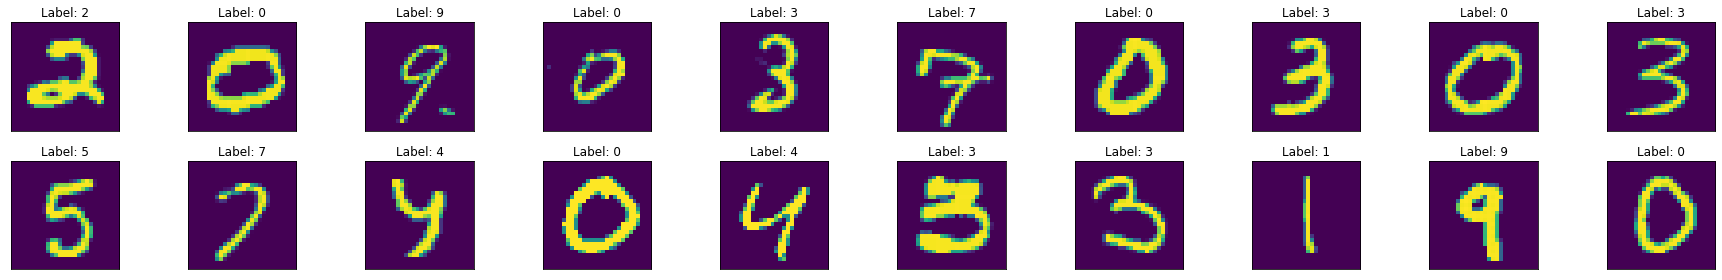

In [17]:
images = iter(comp_loader).next()

fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.set_title(f'Label: {sub_df.loc[i, "Label"]}')
    ax.imshow(images[i].squeeze())

plt.tight_layout()
plt.show()

Looks pretty good!

In [18]:
sub_df.to_csv('submission_LeNet.csv', index=False)

If you have installed the Kaggle API, and are sure you are ready to submit, run this last cell:

In [37]:
# ! kaggle competitions submit -c digit-recognizer -f submission_LeNet.csv -m "same as last +10 epochs"

100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 65.1kB/s]
Successfully submitted to Digit Recognizer